In [1]:
import plotly 
plotly.tools.set_credentials_file(username='davidsx', api_key='QaugK7BhP7fEEnqfvgHm')

In [2]:
sc

<SparkContext master=spark://ec2-52-198-32-10.ap-northeast-1.compute.amazonaws.com:7077 appName=PySparkShell>

In [3]:
sc.setLogLevel("Warn")

In [4]:
sqlContext

In [5]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [6]:
dataSF = sc.textFile('s3a://davidsx/dataSFcrime/xaa.csv')

In [7]:
dataSF.map(lambda line: line.split(','))

PythonRDD[2] at RDD at PythonRDD.scala:53

In [8]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

# IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
# 150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.42158168137,37.7617007179518,"(37.7617007179518, -122.42158168137)",15006027571000

In [9]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [10]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("Hour", hour("Datetime")).withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [11]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [12]:
crime_count = crimeDF.groupBy('Category')\
           .agg({'IncidntNum' : 'count'})\
           .select(col('count(IncidntNum)').alias('catCount'),col('Category'))\
           .orderBy('catCount')
# crime_count_100k_top = crime_count.where(crime_count.catCount > 100000)
# crime_count_10k_100k = crime_count.where(crime_count.catCount > 10000).where(crime_count.catCount < 100000)
# crime_count_1k_10k = crime_count.where(crime_count.catCount > 1000).where(crime_count.catCount < 10000)
# crime_count_btm_1k = crime_count.where(crime_count.catCount < 1000)
crime_count.show(40,False)

+--------+---------------------------+
|catCount|Category                   |
+--------+---------------------------+
|14      |TREA                       |
|59      |PORNOGRAPHY/OBSCENE MAT    |
|348     |GAMBLING                   |
|431     |SEX OFFENSES, NON FORCIBLE |
|741     |EXTORTION                  |
|813     |BRIBERY                    |
|925     |BAD CHECKS                 |
|1183    |FAMILY OFFENSES            |
|1292    |SUICIDE                    |
|2430    |LOITERING                  |
|2988    |EMBEZZLEMENT               |
|3931    |ARSON                      |
|4083    |LIQUOR LAWS                |
|4440    |RUNAWAY                    |
|5346    |KIDNAPPING                 |
|5672    |DRIVING UNDER THE INFLUENCE|
|8716    |RECOVERED VEHICLE          |
|9826    |DRUNKENNESS                |
|10040   |DISORDERLY CONDUCT         |
|11742   |SEX OFFENSES, FORCIBLE     |
|11891   |STOLEN PROPERTY            |
|16701   |PROSTITUTION               |
|19449   |TRESPASS       

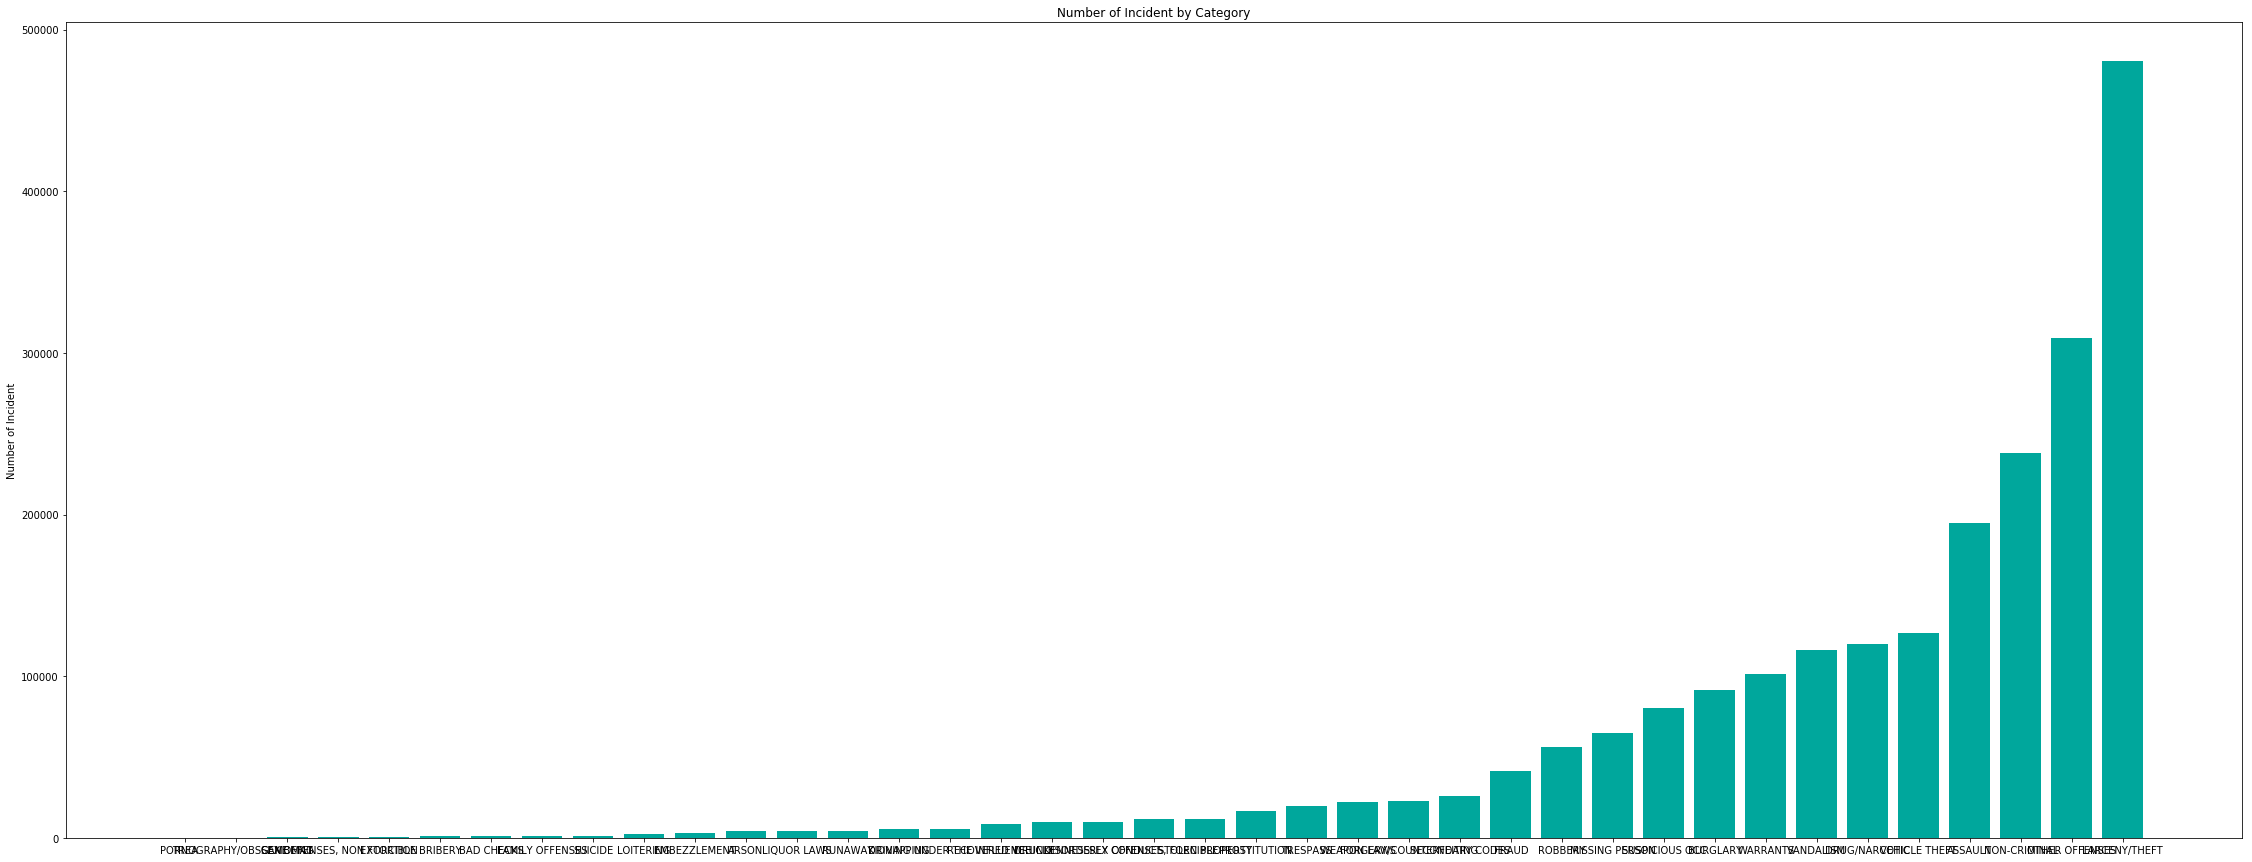

In [13]:
categories = crime_count.select('Category').rdd.map(lambda x: x[0]).collect()

_df = crime_count.toPandas()
category_index = range(len(categories))
ind = np.arange(len(categories))

fig = plt.figure(figsize=(len(category_index),15))

ax = fig.add_subplot(111)
ax.set_xticklabels(categories)
ax.set_xticks(ind)
ax.set_ylabel('Number of Incident')
ax.set_title('Number of Incident by Category')
ax.bar(category_index,_df.catCount, color = '#00a79c')

def plotCrime(df,h):
    crime_list = df.select('Category').rdd.map(lambda x: x[0]).collect()
    
    _df = df.toPandas()
    category_index = range(len(crime_list))
    ind = np.arange(len(crime_list))

    fig = plt.figure(figsize=(len(crime_list)+5,h))

    ax = fig.add_subplot(111)
    ax.set_xticklabels(crime_list)
    ax.set_xticks(ind)
    ax.set_ylabel('Number of Incident')
    ax.set_title('Number of Incident by Category')
    ax.bar(category_index,_df.catCount, color = '#00a79c')

In [14]:
gb = crimeDF.select('Hour','Category').orderBy('Category','Hour').groupBy('Hour','Category')
gbl = gb.agg({"*": "count"}).collect()
categories = crime_count.select('Category').rdd.map(lambda x: x[0]).collect()
n_categories = len(categories)
# matrix where the x-axis is the hour, and y-axis is the category
img_src = np.zeros((n_categories, 24))

In [15]:
for row in gbl :
    print(row[0]) #Hour
    print(row[1]) #Category
    print(row[2]) #count
    print(categories.index(row[1]))

0
ARSON
257
11
1
ARSON
244
11
2
ARSON
264
11
3
ARSON
262
11
4
ARSON
219
11
5
ARSON
170
11
6
ARSON
117
11
7
ARSON
89
11
8
ARSON
93
11
9
ARSON
82
11
10
ARSON
86
11
11
ARSON
83
11
12
ARSON
112
11
13
ARSON
120
11
14
ARSON
117
11
15
ARSON
140
11
16
ARSON
120
11
17
ARSON
157
11
18
ARSON
153
11
19
ARSON
165
11
20
ARSON
196
11
21
ARSON
194
11
22
ARSON
236
11
23
ARSON
255
11
0
ASSAULT
10855
35
1
ASSAULT
9256
35
2
ASSAULT
8389
35
3
ASSAULT
4283
35
4
ASSAULT
2722
35
5
ASSAULT
2188
35
6
ASSAULT
2891
35
7
ASSAULT
4289
35
8
ASSAULT
6527
35
9
ASSAULT
7210
35
10
ASSAULT
7971
35
11
ASSAULT
8482
35
12
ASSAULT
10516
35
13
ASSAULT
9120
35
14
ASSAULT
9279
35
15
ASSAULT
10399
35
16
ASSAULT
10239
35
17
ASSAULT
10452
35
18
ASSAULT
10266
35
19
ASSAULT
10039
35
20
ASSAULT
9903
35
21
ASSAULT
10273
35
22
ASSAULT
9828
35
23
ASSAULT
9317
35
0
BAD CHECKS
162
6
1
BAD CHECKS
3
6
2
BAD CHECKS
2
6
3
BAD CHECKS
3
6
4
BAD CHECKS
3
6
5
BAD CHECKS
2
6
6
BAD CHECKS
3
6
7
BAD CHECKS
12
6
8
BAD CHECKS
49
6
9
BAD CHECKS
65
6
10

2180
28
0
NON-CRIMINAL
10795
36
1
NON-CRIMINAL
5862
36
2
NON-CRIMINAL
4570
36
3
NON-CRIMINAL
3113
36
4
NON-CRIMINAL
2272
36
5
NON-CRIMINAL
2242
36
6
NON-CRIMINAL
4184
36
7
NON-CRIMINAL
6906
36
8
NON-CRIMINAL
10320
36
9
NON-CRIMINAL
11543
36
10
NON-CRIMINAL
12913
36
11
NON-CRIMINAL
12833
36
12
NON-CRIMINAL
17551
36
13
NON-CRIMINAL
13717
36
14
NON-CRIMINAL
13663
36
15
NON-CRIMINAL
14323
36
16
NON-CRIMINAL
14430
36
17
NON-CRIMINAL
13554
36
18
NON-CRIMINAL
12763
36
19
NON-CRIMINAL
11143
36
20
NON-CRIMINAL
10325
36
21
NON-CRIMINAL
10164
36
22
NON-CRIMINAL
9975
36
23
NON-CRIMINAL
9162
36
0
OTHER OFFENSES
18911
37
1
OTHER OFFENSES
8840
37
2
OTHER OFFENSES
7333
37
3
OTHER OFFENSES
4890
37
4
OTHER OFFENSES
3677
37
5
OTHER OFFENSES
2859
37
6
OTHER OFFENSES
4198
37
7
OTHER OFFENSES
8344
37
8
OTHER OFFENSES
12958
37
9
OTHER OFFENSES
14574
37
10
OTHER OFFENSES
14178
37
11
OTHER OFFENSES
14066
37
12
OTHER OFFENSES
20182
37
13
OTHER OFFENSES
15554
37
14
OTHER OFFENSES
15710
37
15
OTHER OFFENSES
16554

In [16]:
# add the frequencies of crime per hour in the matrix
for row in gbl:
    hour = row[0]
    category = row[1]
    value = row[2]
    img_src[categories.index(category)][hour] = value

In [17]:
for row in img_src:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

In [18]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

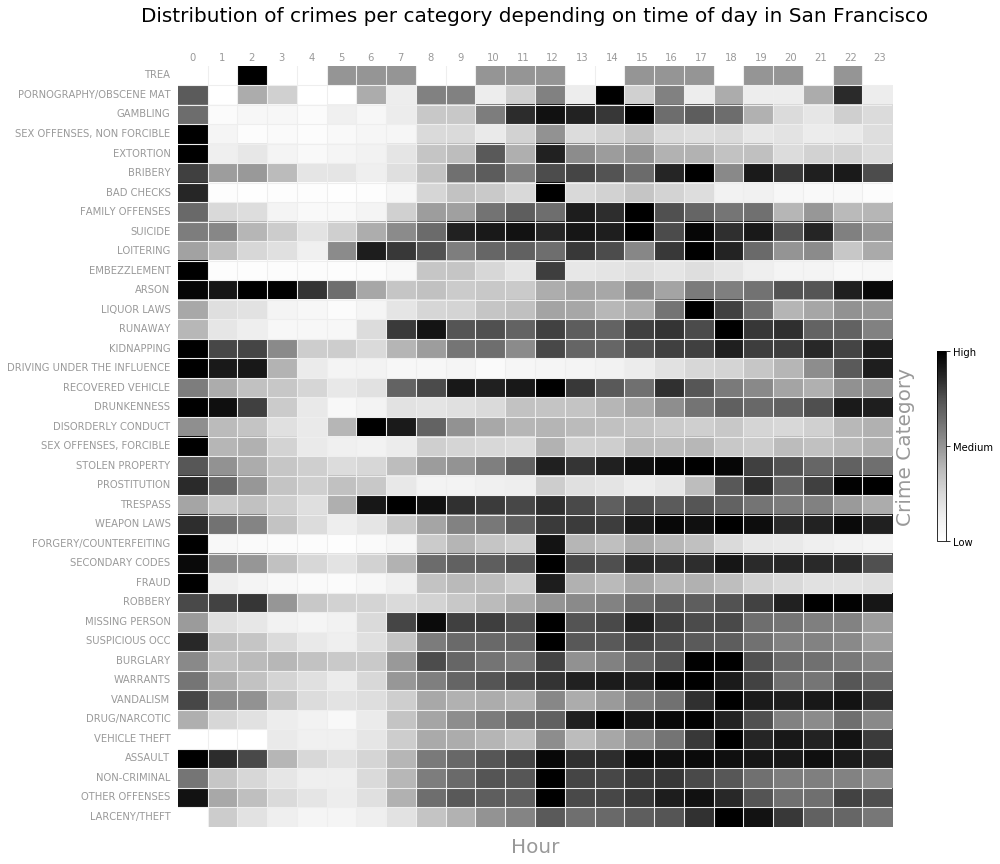

<Figure size 432x288 with 0 Axes>

In [19]:
# draw grid on axes
fig, ax = preparePlot(np.arange(.5, 23, 1), np.arange(.5, n_categories-1, 1), figsize=(16,14), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_src, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# x-axis labels
for x, y, s in zip(np.arange(-.125, 24, 1), np.repeat(-.75, 24), [str(x) for x in range(24)]):
    plt.text(x, y, s, color='#999999', size='10')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, n_categories), np.arange(.125, n_categories, 1), categories):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
plt.title("Distribution of crimes per category depending on time of day in San Francisco", size=20, y=1.05)
plt.xlabel("Hour", color='#999999', size="20")
plt.ylabel("Crime Category", color='#999999', size="20")
ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()
plt.savefig('result/crime_distribution.pdf')



In [ ]:
sf_night_crimes = crimeDF.where(((col('Hour') >= 18) | (col('Hour') <= 6)).groupBy()

In [20]:
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

from descartes import PolygonPatch

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep

from itertools import chain

import fiona

In [21]:
shp = fiona.open('sffind_neighborhoods.shp')

In [22]:
# Extract map boundaries
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
# width, height of map
w, h = coords[2] - coords[0], coords[3] - coords[1]

Read SF neighborhood data into Basemap


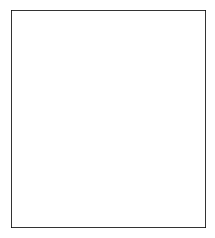

In [23]:
m = Basemap(
    projection='tmerc',
    lon_0=-122.,
    lat_0=37.7,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    'sffind_neighborhoods',
    'SF',
    color='none',
    zorder=2)

print "Read SF neighborhood data into Basemap"

In [24]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.SF],
    'ward_name': [ward['name'] for ward in m.SF_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
# Draw neighborhoods with polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#000000',
    ec='#ffffff', lw=.5, alpha=1,
    zorder=4))

In [25]:
dataset = crimeDF

In [ ]:
def makePoints(dat):
    # Create Point objects in map coordinates from dataframe lon and lat values
    longitude = dat.select('Longitude').rdd.map(lambda x: x[0]).collect()
    latitude = dat.select('Latitude').rdd.map(lambda x: x[0]).collect()
    map_points = pd.Series([Point(m(mapped_x,mapped_y)) for mapped_x, mapped_y in zip(longitude,latitude)])
    plt_points = MultiPoint(list(map_points.values))
    hoods_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
    pts = filter(hoods_polygon.contains,plt_points)
    return pts

night_crimes = [
    "VEHICLE THEFT", 
    "ROBBERY", 
    "PROSTITUTION", 
    "LARCENY/THEFT",
    "DRUNKENNESS",
    "ASSAULT"
]
crime_from_2017 = crimeDF.where(col('Year')>2016)
sf_night_crimes = crime_from_2017.where(((col('Hour') >= 18) | (col('Hour') <= 6))&(col('Category').isin(night_crimes)))
# sf_night_crimes.show()

sf_night_vehicle_theft = sf_night_crimes.where(col('Category')==night_crimes[0])
sf_night_robbery = sf_night_crimes.where(col('Category')==night_crimes[1])
sf_night_prostitution = sf_night_crimes.where(col('Category')==night_crimes[2])
sf_night_theft = sf_night_crimes.where(col('Category')==night_crimes[3])
sf_night_drunk = sf_night_crimes.where(col('Category')==night_crimes[4])
sf_night_assault = sf_night_crimes.where(col('Category')==night_crimes[5])

print(sf_night_vehicle_theft.count())
print(sf_night_robbery.count())
print(sf_night_prostitution.count())
print(sf_night_theft.count())
print(sf_night_drunk.count())
print(sf_night_assault.count())

sf_night_crimes_points = makePoints(sf_night_crimes)
sf_night_vehicle_theft_points = makePoints(sf_night_vehicle_theft)
sf_night_robbery_points = makePoints(sf_night_robbery)
sf_night_prostitution_points = makePoints(sf_night_prostitution)
sf_night_theft_points = makePoints(sf_night_theft)
sf_night_drunk_points = makePoints(sf_night_drunk)
sf_night_assault_points = makePoints(sf_night_assault)

<Figure size 432x288 with 0 Axes>

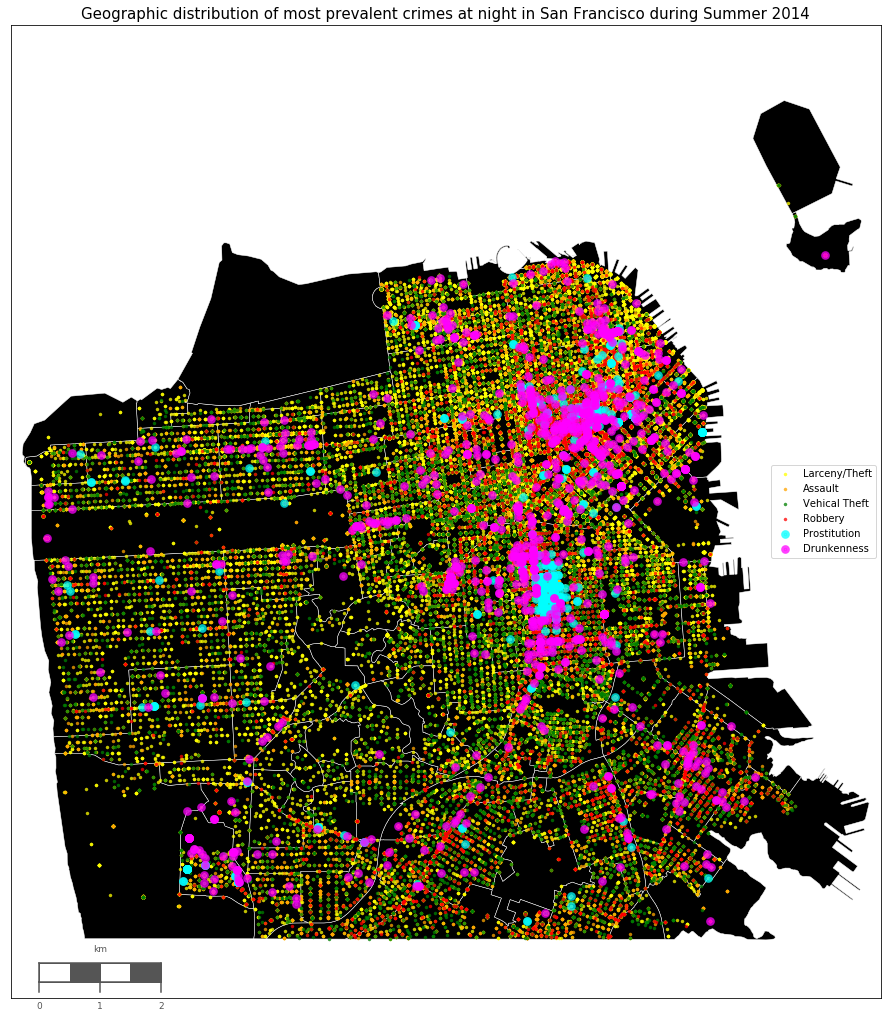

In [55]:
plt.clf()
fig = plt.figure()
fig.add_axes(frameon=False, axisbg='w')
ax = fig.add_subplot(111)

sf_night_crimes_list = [sf_night_vehicle_theft_points,sf_night_robbery_points,sf_night_prostitution_points,\
                       sf_night_theft_points,sf_night_drunk_points,sf_night_assault_points]
pts_color = ['green', 'red', 'cyan', 'yellow', 'magenta', 'orange'] #green,red,orange,yellow,magenta,cyan
pts_label = ['Vehical Theft', 'Robbery', 'Prostitution', 'Larceny/Theft', 'Drunkenness', 'Assault']
pts_lw = [.25,.25,5.5,.25,5.5,.25]

def bmScatter(pts_index): 
    m.scatter(
    [geom.x for geom in sf_night_crimes_list[pts_index]],
    [geom.y for geom in sf_night_crimes_list[pts_index]],
    10, marker='o', lw=pts_lw[pts_index],
    facecolor=pts_color[pts_index], edgecolor=pts_color[pts_index],
    alpha=0.75, antialiased=True,
    label=pts_label[pts_index], zorder=3)
    
bmScatter(3)
bmScatter(5)
bmScatter(0)
bmScatter(1)
bmScatter(2)
bmScatter(4)
    
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

m.drawmapscale(
    coords[0] + 0.015, coords[1] - 0.005,
    coords[0], coords[1],
    2.,
    barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555',
    fontcolor='#555555',
    zorder=5)

plt.tight_layout()
plt.legend(loc="center right")
plt.title("Geographic distribution of most prevalent crimes at night in San Francisco during Summer 2014", size=15)
fig.set_size_inches(15,15)
plt.show()

In [71]:
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, sf_night_crimes_points))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

df_map.sample(n=5)

,poly,ward_name,area_m,area_km,patches,count,density_m,density_km
107,"POLYGON ((10056.4417145093 10433.83967931288, ...",Financial District,8.283299e+05,8.283299,"Poly((10056.4, 10433.8) ...)",6788,0.008195,819.480265
14,"POLYGON ((6999.872550943808 11097.35866117204,...",Union Street,4.862087e+05,4.862087,"Poly((6999.87, 11097.4) ...)",4217,0.008673,867.323083
13,"POLYGON ((6189.674489848672 10552.50536306072,...",Cow Hollow,3.949074e+05,3.949074,"Poly((6189.67, 10552.5) ...)",1318,0.003337,333.749148
82,"POLYGON ((8723.906357005857 4379.785139743383,...",Bernal Heights,1.726502e+06,17.265019,"Poly((8723.91, 4379.79) ...)",7190,0.004164,416.449016
98,"POLYGON ((8545.156955302788 11662.60432284508,...",Fishermans Wharf,6.625231e+05,6.625231,"Poly((8545.16, 11662.6) ...)",5943,0.008970,897.025356


In [106]:
from pysal.esda.mapclassify import Natural_Breaks as nb

# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=5)

prev = 0
for density, counts in zip(breaks.bins, breaks.counts):
    print "%d neighborhoods have crime density D such as %d/km^2 <= D <= %d/km^2" % (counts, prev, density)
    prev = density

ImportError: cannot import name _voronoi

In [101]:
from scipy import spatial

ImportError: cannot import name _voronoi

In [1]:
import pysal

ImportError: libquadmath.so.0: cannot open shared object file: No such file or directory